In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy
import seaborn as sns
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Again asking the question, are clinvar variants that are in amino acids that are near glycosites more likely to be pathogenic than ones that are not, but now with continuous values

In [2]:
path_dct = {'benign':1,
            'likely benign':2,
            'likely pathogenic':3,
            'pathogenic':4}

In [3]:
df = pd.read_csv('../data/clinvar_glycoproteins_distances.txt',
                 sep='\t',
                index_col=0)
df = df.sort_values(by='clinvar_path')
df['clinvar_path_val'] = [path_dct[c] for c in df['clinvar_path']]
df['log_distance'] = np.log10(df['distance_to_feature'])

Text(0,0.5,'log10(distance to N-Gly)')

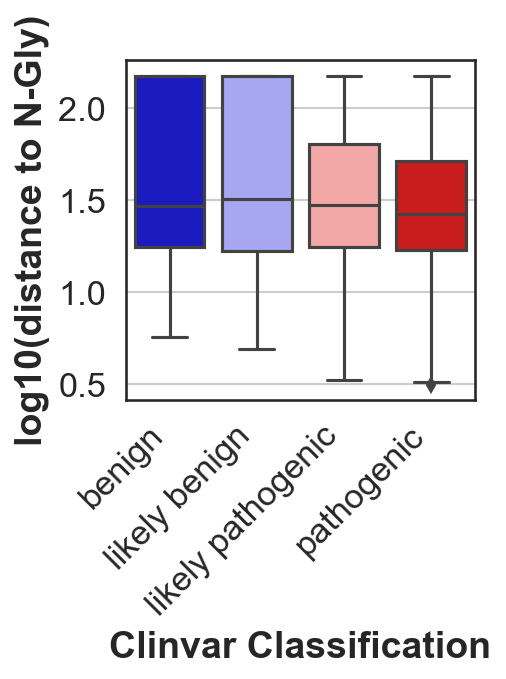

In [23]:
sns.set_context("paper")
    
# Set the font to be serif, rather than sans
sns.set(font='arial',font_scale=1.5)

# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "arial",'axes.grid': True,"font.size":14,"axes.labelsize":14})

plt.figure(dpi=150,figsize=(3,3))
df = df.sort_values(by='clinvar_path')
sns.boxplot(x='clinvar_path',
            y='log_distance',
            data=df,
            palette='seismic',)
plt.xlabel('Clinvar Classification',fontweight='bold')
plt.xticks(rotation='45',ha='right')
plt.ylabel('log10(distance to N-Gly)',fontweight='bold')

In [6]:
formula = 'clinvar_path_val ~ distance_to_feature'

model = smf.ols(formula=formula, data=df).fit()

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       clinvar_path_val   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     45.20
Date:                Wed, 25 Mar 2020   Prob (F-statistic):           2.12e-11
Time:                        11:13:45   Log-Likelihood:                -4102.4
No. Observations:                3010   AIC:                             8209.
Df Residuals:                    3008   BIC:                             8221.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               3.5852      0.025    146.119      0.000       3.537       3.633
distance_to_feature    -0.0023      0.000     -6.723      0.000      -0.003      -0.002
==============================================================================
Omnibus:                      792.776   Durbin-Watson:                   0.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1573.849
Skew:                          -1.628   Prob(JB):                         0.00
Kurtosis:                       4.395   Cond. No.                         104.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Looking at relationships on a per amino acid change level

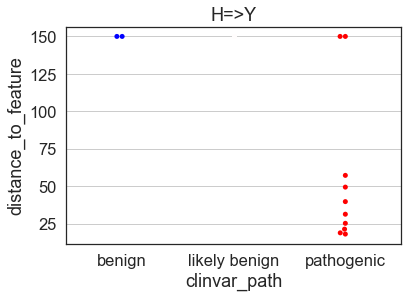

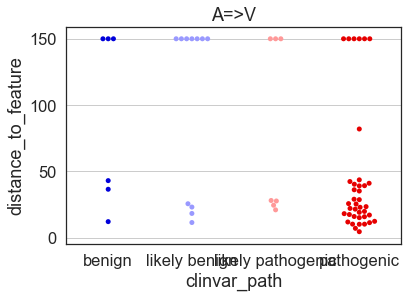

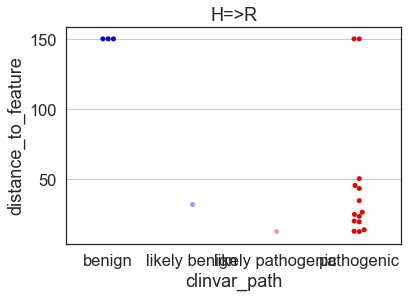

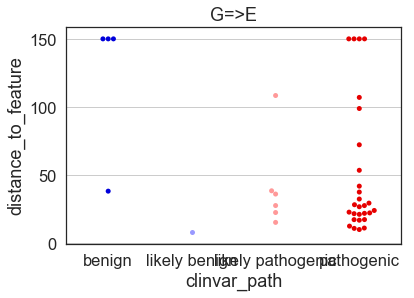

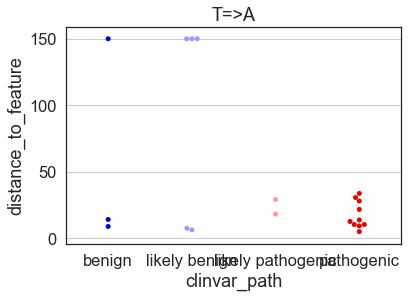

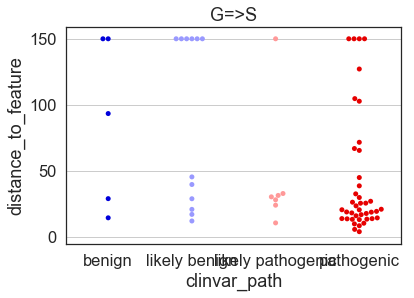

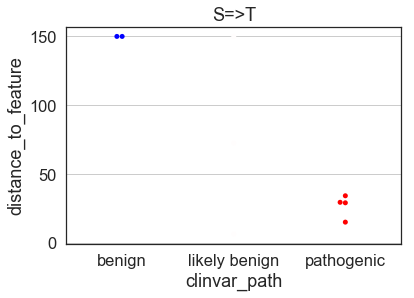

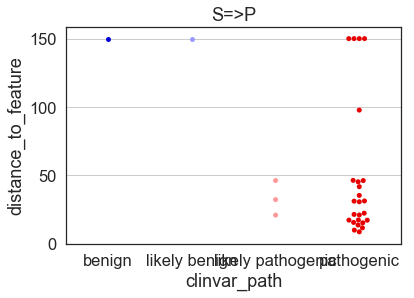

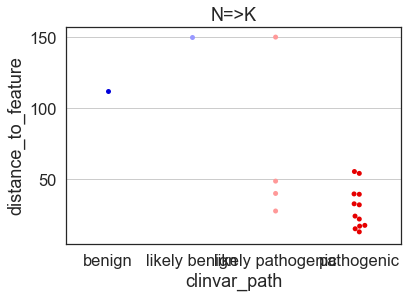

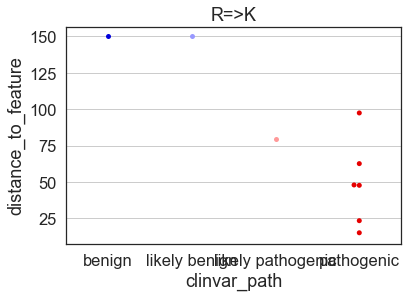

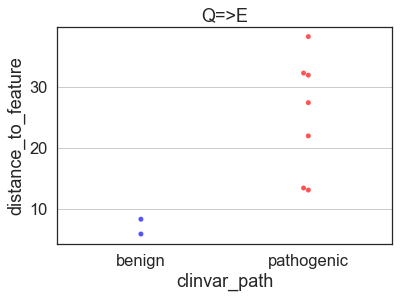

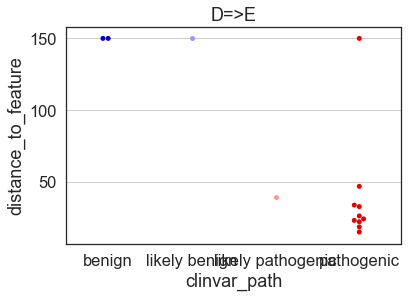

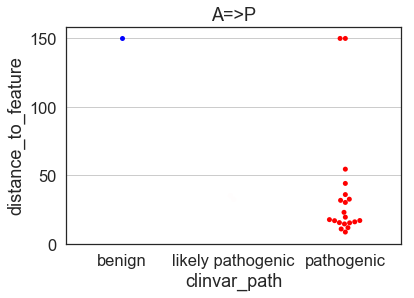

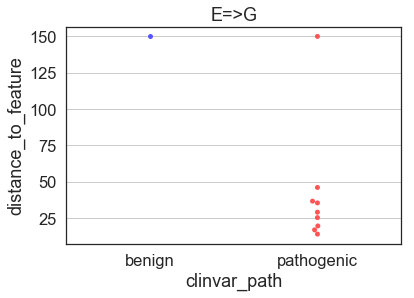

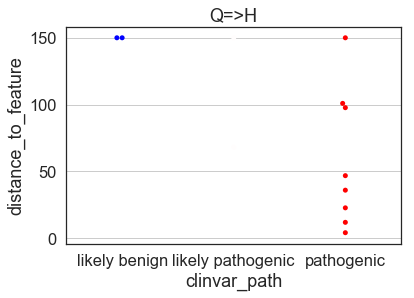

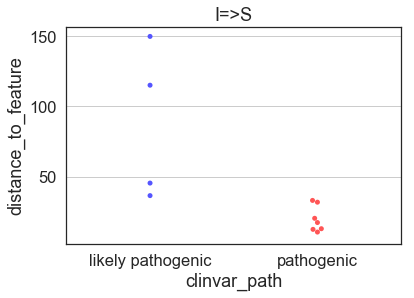

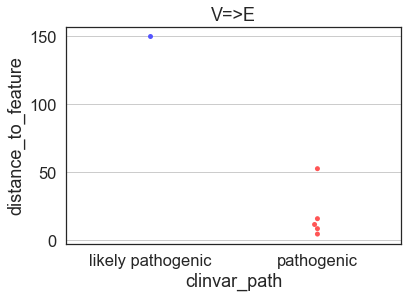

In [8]:
for ac in df['aa_change'].unique():
    aa_df = df[df['aa_change'] == ac]
    
    if aa_df.shape[0] < 3 or len(aa_df['clinvar_path'].unique()) < 2:
        continue
        
    formula = 'clinvar_path_val ~ distance_to_feature'

    model = smf.ols(formula=formula, data=aa_df).fit()  
    p = model.pvalues['distance_to_feature']
    
    if p < 0.05:
        
        sns.swarmplot(x='clinvar_path',
                        y='distance_to_feature',
                        data=aa_df,
                        palette='seismic',)

        plt.title(ac)
        plt.show()

## Looking on a per class basis

In [56]:
aa_class = pd.read_csv('../data/glyco_protein_impact_within_6.csv')

In [57]:
high_med_glyco_neg_prot = aa_class[aa_class['glyco_impact'].isin(['high','medium']) & (aa_class['proteinStruct_impact'] == 'negligable - frequent')]
high_med_glyco_neg_prot

,substitution,glyco_distance,Blosum64,glyco_impact,proteinStruct_impact
15,A=>V,25.950160,0,medium,negligable - frequent
43,D=>Q,28.903581,0,medium,negligable - frequent
66,F=>W,33.752997,1,high,negligable - frequent
67,F=>Y,33.526628,3,high,negligable - frequent
91,I=>F,33.608746,0,high,negligable - frequent
98,I=>V,24.800146,3,medium,negligable - frequent
109,L=>F,33.819905,0,high,negligable - frequent
115,L=>V,25.122326,1,medium,negligable - frequent
118,M=>F,33.549813,0,high,negligable - frequent
122,M=>V,24.747438,1,medium,negligable - frequent


In [58]:
high_glyco_neg_prot = aa_class[aa_class['glyco_impact'].isin(['high']) & (aa_class['proteinStruct_impact'] == 'negligable - frequent')]
high_glyco_neg_prot

,substitution,glyco_distance,Blosum64,glyco_impact,proteinStruct_impact
66,F=>W,33.752997,1,high,negligable - frequent
67,F=>Y,33.526628,3,high,negligable - frequent
91,I=>F,33.608746,0,high,negligable - frequent
109,L=>F,33.819905,0,high,negligable - frequent
118,M=>F,33.549813,0,high,negligable - frequent
135,Q=>K,30.625659,1,high,negligable - frequent


In [59]:
low_glyco_neg_prot = aa_class[aa_class['glyco_impact'].isin(['low']) & (aa_class['proteinStruct_impact'] == 'negligable - frequent')]
low_glyco_neg_prot

,substitution,glyco_distance,Blosum64,glyco_impact,proteinStruct_impact
0,A=>C,9.051015,0,low,negligable - frequent
4,A=>G,7.815168,0,low,negligable - frequent
13,A=>S,11.126291,1,low,negligable - frequent
14,A=>T,14.766297,0,low,negligable - frequent
34,D=>E,6.918130,2,low,negligable - frequent
44,D=>S,3.538718,0,low,negligable - frequent
51,E=>H,7.444015,0,low,negligable - frequent
53,E=>K,11.851892,1,low,negligable - frequent
57,E=>S,8.799551,0,low,negligable - frequent
75,G=>S,3.531126,0,low,negligable - frequent


(43, 9)
0.813389651636594


/Users/d/work/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


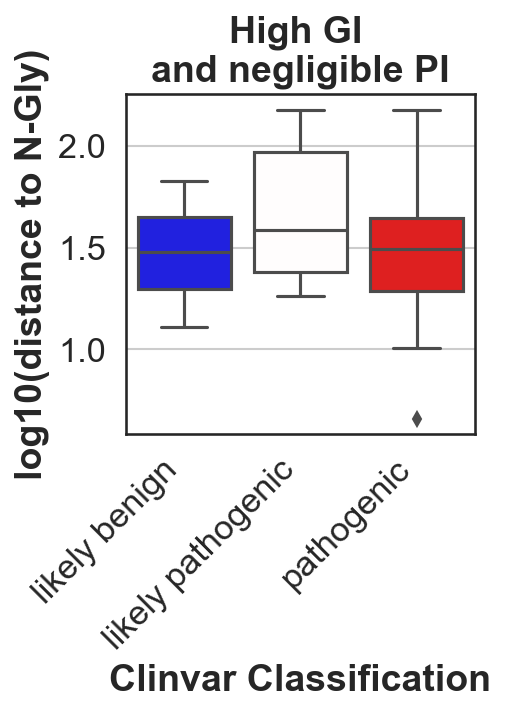

(307, 9)
0.001980573253423067


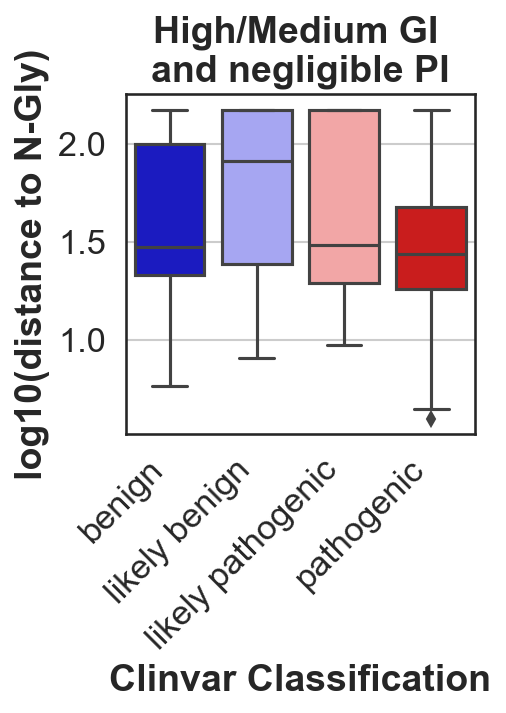

(407, 9)
7.006555743889133e-05


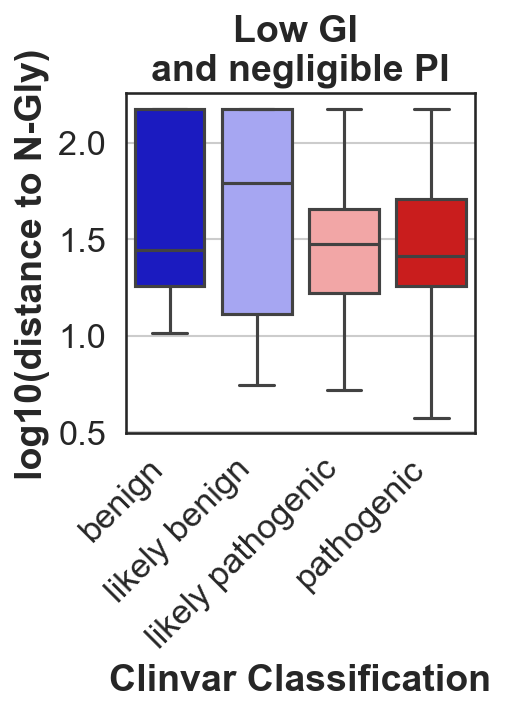

In [61]:
classifications = [(high_glyco_neg_prot,'High GI \nand negligible PI'),
                   (high_med_glyco_neg_prot,'High/Medium GI \nand negligible PI'),
                   (low_glyco_neg_prot,'Low GI \nand negligible PI')]

lst_ = []

for aa_classes in classifications:
    
    aa_class,label = aa_classes
    
    aas = aa_class['substitution'].to_list()
    aa_df = df[df['aa_change'].isin(aas)]
    aa_df['GI_PI_type'] = label
    lst_.append(aa_df)
    
    formula = 'clinvar_path_val ~ distance_to_feature'

    model = smf.ols(formula=formula, data=aa_df).fit()  
    p = model.pvalues['distance_to_feature']
    print(aa_df.shape)
    print(p)
    plt.figure(dpi=150,figsize=(3,3))
    sns.boxplot(x='clinvar_path',
                    y='log_distance',
                    data=aa_df,
                    palette='seismic',)

    plt.title(label,fontweight='bold')
    plt.xlabel('Clinvar Classification',fontweight='bold')
    plt.xticks(rotation='45',ha='right')
    plt.ylabel('log10(distance to N-Gly)',fontweight='bold')
    plt.show()

In [62]:
concat_df = pd.concat(lst_,axis=0)
concat_df

,aa,protein,clinvar_path,aa_change,clinvar_index,distance_to_feature,clinvar_path_val,log_distance,GI_PI_type
152803,331.0,P06280,likely benign,L=>F,36687,30.08,2,1.478278,High GI \nand negligible PI
132243,255.0,P13569,likely benign,I=>F,31259,66.73,2,1.824321,High GI \nand negligible PI
119949,72.0,P07686,likely benign,L=>F,27823,12.93,2,1.111599,High GI \nand negligible PI
118854,294.0,P16871,likely pathogenic,L=>F,27460,150.00,3,2.176091,High GI \nand negligible PI
152822,242.0,P06280,likely pathogenic,I=>F,36716,24.86,3,1.395501,High GI \nand negligible PI
20826,588.0,P51787,likely pathogenic,I=>F,4608,150.00,3,2.176091,High GI \nand negligible PI
20419,337.0,P51787,likely pathogenic,I=>F,4467,21.26,3,1.327563,High GI \nand negligible PI
20542,375.0,P51787,likely pathogenic,I=>F,4515,79.83,3,1.902166,High GI \nand negligible PI
152815,275.0,P06280,likely pathogenic,L=>F,36706,34.77,3,1.541205,High GI \nand negligible PI
132248,333.0,P13569,likely pathogenic,L=>F,31263,18.25,3,1.261263,High GI \nand negligible PI


(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

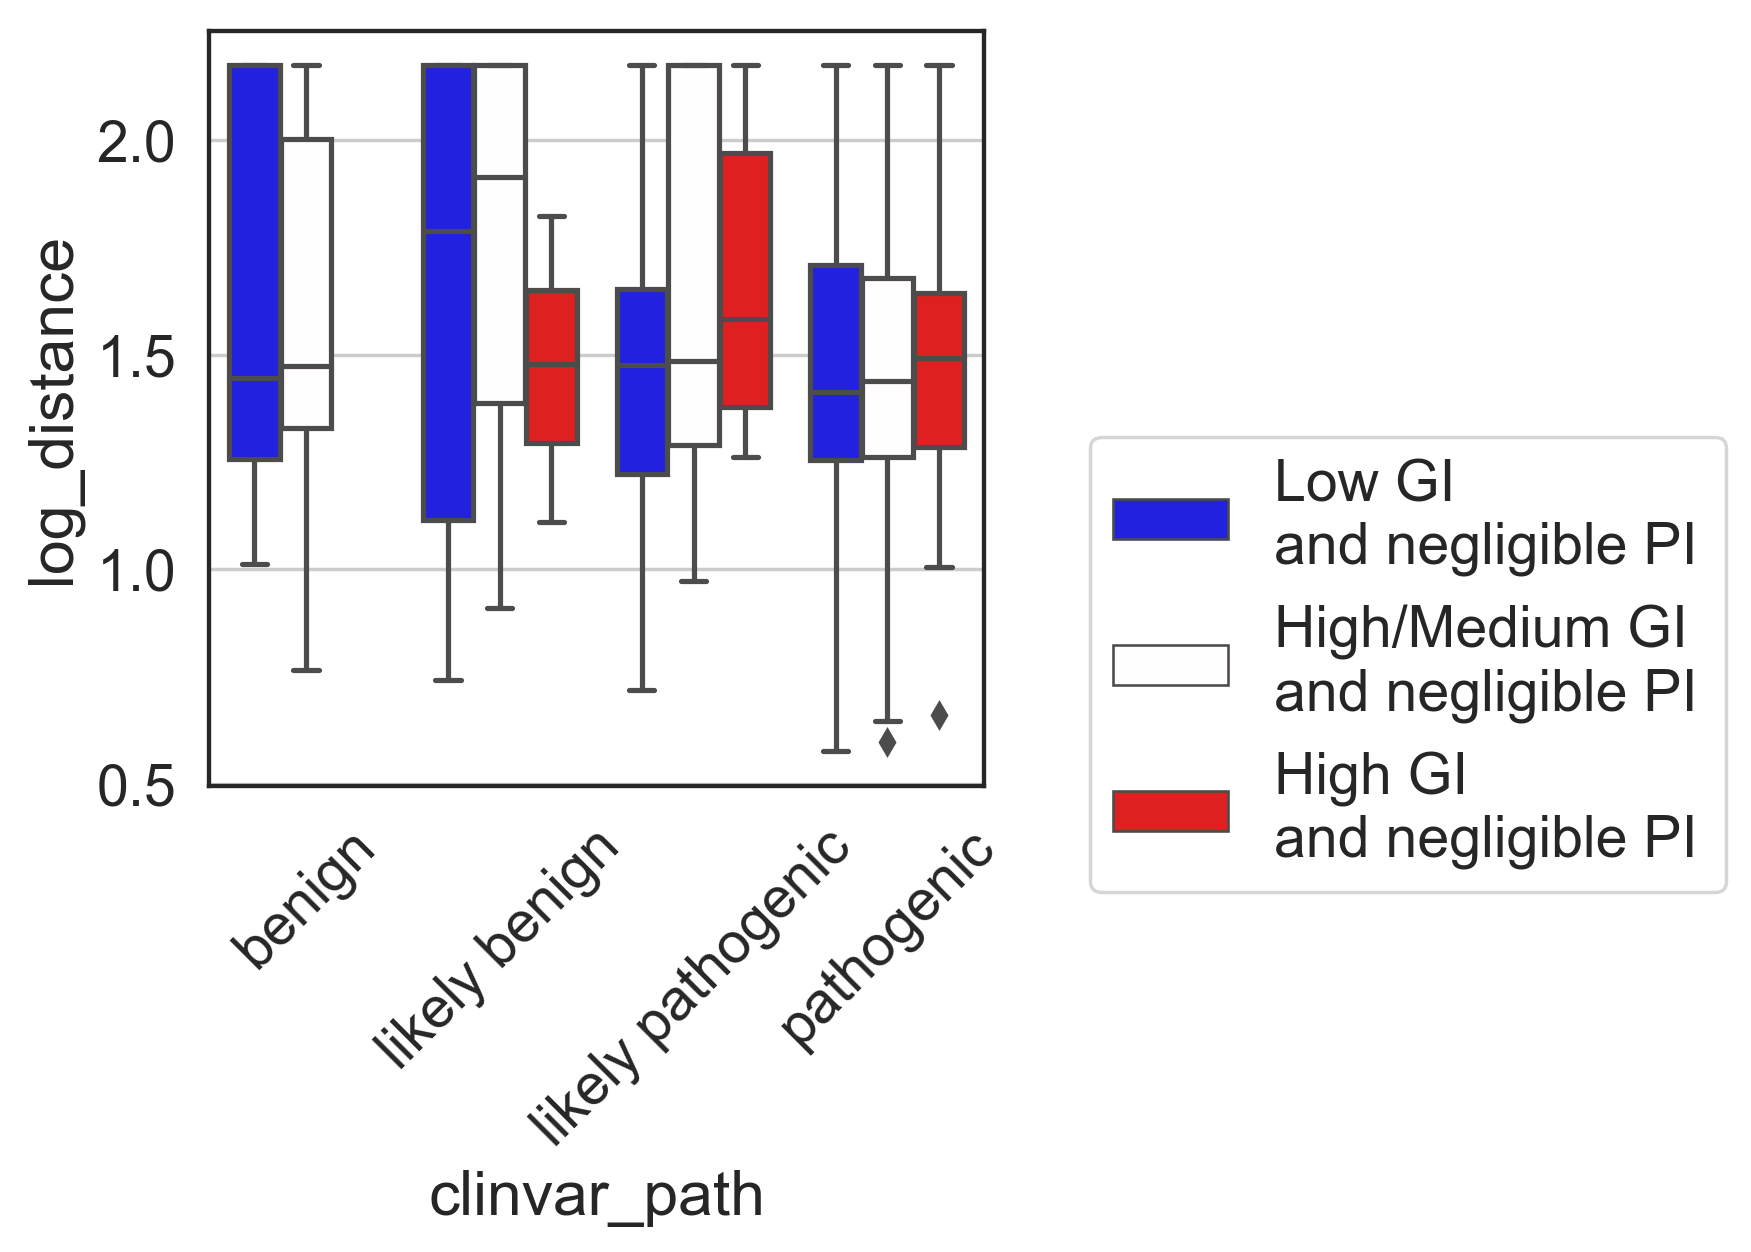

In [68]:
plt.figure(dpi=250,figsize=(4,4))
concat_df = concat_df.sort_values(by='clinvar_path')
sns.boxplot(data=concat_df,
               x='clinvar_path',
               y='log_distance',
               palette='seismic',
               hue='GI_PI_type')
plt.legend(bbox_to_anchor=(1.1,0.5))
plt.xticks(rotation='45')

## Now looking generally at counts that belong to each category

In [69]:
table = concat_df.groupby(by=['clinvar_path','GI_PI_type'],as_index=False).count()[['clinvar_path','GI_PI_type','aa']]

In [71]:
pivot_table = table.pivot(columns='GI_PI_type',values='aa',index='clinvar_path').fillna(0)

In [75]:
pivot_table.loc['all_path'] = pivot_table.loc['likely pathogenic'] + pivot_table.loc['pathogenic']
pivot_table.loc['all_benign'] = pivot_table.loc['likely benign'] + pivot_table.loc['benign']

In [76]:
pivot_table

GI_PI_type,High GI and negligible PI,High/Medium GI and negligible PI,Low GI and negligible PI
clinvar_path,,,
benign,0.0,37.0,51.0
likely benign,3.0,28.0,35.0
likely pathogenic,8.0,41.0,49.0
pathogenic,32.0,201.0,272.0
all_path,40.0,242.0,321.0
all_benign,3.0,65.0,86.0


In [87]:
test_rows = [['benign','pathogenic'],
             ['all_benign','all_path']]
test_cols = [['High GI \nand negligible PI','Low GI \nand negligible PI'],
             ['High/Medium GI \nand negligible PI','Low GI \nand negligible PI']]

## Fisher Exact:

In [94]:
for col in test_cols:
    for row in test_rows:
        cont_table = pivot_table[col].loc[row]
        odds,p = scipy.stats.fisher_exact(cont_table)
        print(cont_table)
        print()
        print('p = {}'.format(p))
        print()

GI_PI_type    High GI \nand negligible PI  Low GI \nand negligible PI
clinvar_path                                                         
benign                                0.0                        51.0
pathogenic                           32.0                       272.0

p = 0.007724960303841937

GI_PI_type    High GI \nand negligible PI  Low GI \nand negligible PI
clinvar_path                                                         
all_benign                            3.0                        86.0
all_path                             40.0                       321.0

p = 0.026031270366811913

GI_PI_type    High/Medium GI \nand negligible PI  Low GI \nand negligible PI
clinvar_path                                                                
benign                                      37.0                        51.0
pathogenic                                 201.0                       272.0

p = 1.0

GI_PI_type    High/Medium GI \nand negligible PI  Low GI \nand negli